In [37]:
import sys

sys.path.append('../')

import os
import cv2
import torch
import seaborn as sns
import numpy as np
import models_mae
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from util.pos_embed import interpolate_pos_embed

In [8]:
arch='mae_vit_large_patch16'
# arch='mae_vit_base_patch16'
model_mae = getattr(models_mae, arch)()

# chkpt_dir = '/mnt/lwll/lwll-coral/hrant/mae_objectness/SSL-playground/consistency_learning_utils/nets/oracle/mae/checkpoints/mae_pretrain_vit_base.pth'

chkpt_dir = '/mnt/lwll/lwll-coral/hrant/mae_checkpoints/mae_checkpoints/mae_visualize_vit_large_ganloss.pth'
checkpoint = torch.load(chkpt_dir, map_location='cpu')
# msg = model_mae.load_state_dict(checkpoint['model'], strict=False)
# print(msg)

In [4]:
interpolate_pos_embed(model_mae, checkpoint['model'])

Position interpolate from 14x14 to 90x90


In [9]:
state_dict = checkpoint['model']

In [10]:
n, c, hw = state_dict['pos_embed'].transpose(1, 2).shape

In [11]:
n, c, hw

(1, 1024, 197)

In [12]:
n, c, hw = state_dict['pos_embed'].transpose(1, 2).shape
h = w = int(hw ** 0.5)
pos_embed_weight = state_dict['pos_embed'][:, (-h * w):]
pos_embed_weight = pos_embed_weight.transpose(1, 2)

n, c, hw = pos_embed_weight.shape
h = w = int(hw ** 0.5)
pos_embed_weight = pos_embed_weight.view(n, c, h, w)

pos_embed_weight = F.interpolate(pos_embed_weight, size=(64, 64*2), mode='bilinear', align_corners=False)

pos_embed_weight = pos_embed_weight.view(n, c, -1).transpose(1, 2)

cls_token_weight = state_dict['pos_embed'][:, 0].unsqueeze(1)

state_dict['pos_embed'] = torch.cat(
    (cls_token_weight, pos_embed_weight), dim=1)

In [13]:
n, c, hw = state_dict['decoder_pos_embed'].transpose(1, 2).shape
h = w = int(hw ** 0.5)
pos_embed_weight = state_dict['decoder_pos_embed'][:, (-h * w):]
pos_embed_weight = pos_embed_weight.transpose(1, 2)

n, c, hw = pos_embed_weight.shape
h = w = int(hw ** 0.5)
pos_embed_weight = pos_embed_weight.view(n, c, h, w)

pos_embed_weight = F.interpolate(pos_embed_weight, size=(64, 64*2), mode='bilinear', align_corners=False)

pos_embed_weight = pos_embed_weight.view(n, c, -1).transpose(1, 2)

cls_token_weight = state_dict['decoder_pos_embed'][:, 0].unsqueeze(1)

state_dict['decoder_pos_embed'] = torch.cat(
    (cls_token_weight, pos_embed_weight), dim=1)

In [14]:
for key in state_dict:
    if 'pos_embed' in key:
        print(key)

pos_embed
decoder_pos_embed


In [15]:
msg = model_mae.load_state_dict(state_dict, strict=False)
msg

<All keys matched successfully>

In [38]:
annot = np.load('../annotations/cs/cs_train.npy', allow_pickle=True).item()

file = annot['images'][10]['file_name'].replace('/leftImg8bit/', '/vision/images/cs/full_ds/')
img = cv2.imread(file)
img = cv2.resize(img, (2044, 1022))

In [9]:
annot = np.load('../annotations/f1m/250_16shot_train.npy', allow_pickle=True).item()
i = 1
file = '../images/f1m/250_16shot/train/images/' + annot['images'][i]['file_name']
img = cv2.imread(file)
img = cv2.resize(img, (238, 238))

black_img = annot['images'][i]['black_image']
black_img_new = cv2.resize(black_img, (17, 17), interpolation=cv2.INTER_NEAREST_EXACT)

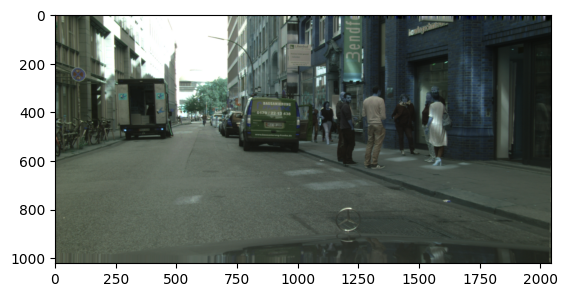

In [39]:
plt.imshow(img);

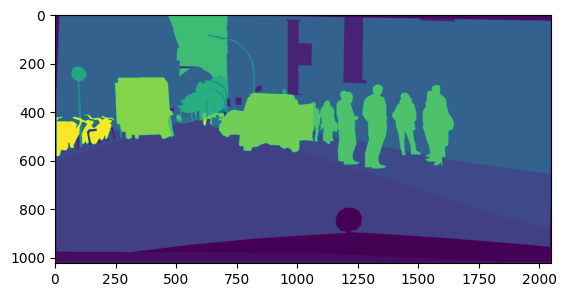

In [42]:
plt.imshow(black_img);

In [66]:
black_img

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

In [65]:
np.unique(black_img, return_counts=True)

(array([ 1,  2,  3,  4,  5,  7,  8, 11, 13, 15, 17, 20, 21, 23, 24, 25, 26,
        27, 33], dtype=uint8),
 array([121096,  74098,  31634,  45289,    445, 621448, 151404, 726044,
          2410,    258,   6194,   3651,  21234,  49078, 101061,    633,
         69278,  51888,  20009]))

In [43]:
black_img = annot['images'][10]['black_image']

In [23]:
file

'/mnt/lwll/lwll-coral/hrant/vision/images/cs/full_ds/train/dusseldorf/dusseldorf_000093_000019_leftImg8bit.png'

In [24]:
img.shape

(1024, 2048, 3)

In [113]:
img_new = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()

In [27]:
img_new.shape

torch.Size([1, 3, 1024, 2048])

In [30]:
img_enc, _, _ = model_mae.forward_encoder(img_new.float(), mask_ratio=0)

In [31]:
img_enc.shape

torch.Size([1, 8193, 1024])

In [44]:
from get_model import get_model

In [45]:
dino = get_model('dinov2', 'cpu')

Loading dino model


Using cache found in /home/hkhachatrian/.cache/torch/hub/facebookresearch_dinov2_main


In [46]:
# img_new = cv2.resize(img, (2044, 1022))
img_new = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()

In [48]:
x = dino.prepare_tokens_with_masks(img_new)
for i, blk in enumerate(dino.blocks):
    x = blk(x)
x = dino.norm(x)
print(x.shape)

# img_emb = dino(img.float())

torch.Size([1, 10659, 768])


In [49]:
x.squeeze_(0)

tensor([[ 2.0033,  0.8953,  0.7297,  ..., -2.6806,  0.6526, -0.8567],
        [ 2.2902, -0.3442, -1.0254,  ...,  0.8022, -1.0736,  0.1340],
        [ 0.9047,  0.6428,  0.2656,  ..., -1.0442, -1.2003, -1.8252],
        ...,
        [ 2.7406, -0.0539, -0.1214,  ..., -2.6344, -0.9853, -1.9200],
        [ 2.7390, -0.1937, -0.4662,  ..., -2.7875, -0.9391, -2.0042],
        [ 0.1617,  0.8788,  1.1701,  ...,  2.0370, -2.5867, -1.5828]],
       grad_fn=<SqueezeBackward3>)

In [50]:
x.shape

torch.Size([10659, 768])

In [52]:
from sklearn.decomposition import PCA

pca = PCA(3)
img_emb_low = pca.fit_transform(x[1:, :].cpu().detach().numpy())

In [53]:
img_emb_low.shape

(10658, 3)

In [54]:
black_img_new = cv2.resize(black_img, (146, 73), interpolation=cv2.INTER_NEAREST_EXACT)

black_img = black_img_new.flatten()
black_img[img_emb_low[:, 0] < 0] = 0

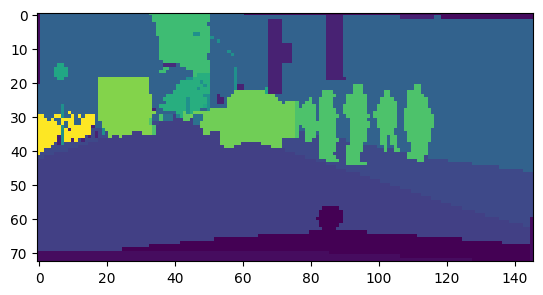

In [55]:
plt.imshow(black_img_new);

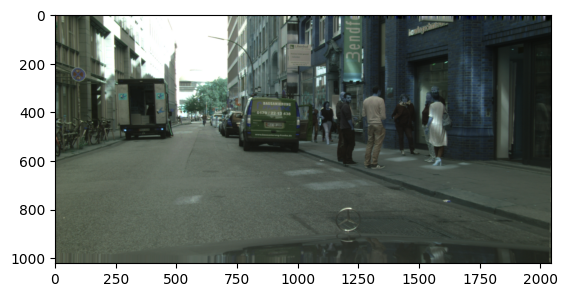

In [56]:
plt.imshow(img);

In [56]:
black_img_new.flatten()

array([21, 21, 21, ...,  7,  7,  7], dtype=uint8)

In [91]:
img_emb_low.shape

(10658, 3)

In [57]:
import pandas as pd

df = pd.DataFrame((black_img_new.reshape(-1), img_emb_low.reshape(-1, 3)[:, 0], \
                   img_emb_low.reshape(-1, 3)[:, 1], img_emb_low.reshape(-1, 3)[:, 2])).T
df[0] = df[0].apply(lambda x: int(x))

In [58]:
df.columns = ['labels', 'pca1', 'pca2', 'pca3']

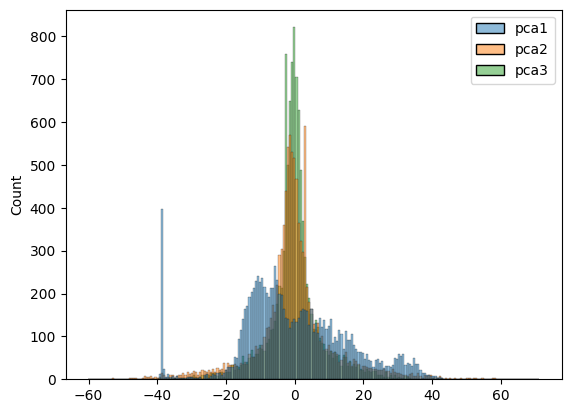

In [59]:
sns.histplot(df[['pca1', 'pca2', 'pca3']]);

In [30]:
range1 = (-20, 40)
range2 = (-30, 35)
range3 = (-20, 40)
red = (df['pca1'] - range1[0])/(range1[1] - range1[0])
green = (df['pca2'] - range2[0])/(range2[1] - range2[0])
blue = (df['pca3'] - range3[0])/(range3[1] - range3[0])

In [60]:
range1 = (-40, 50)
range2 = (-40, 50)
range3 = (-12, 40)
red = (df['pca1'] - range1[0])/(range1[1] - range1[0])
green = (df['pca2'] - range2[0])/(range2[1] - range2[0])
blue = (df['pca3'] - range3[0])/(range3[1] - range3[0])

In [62]:
img = np.stack([red.values, green.values, blue.values]).reshape((3, 73, 146)).transpose((1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


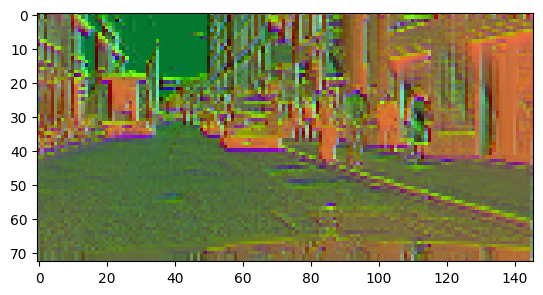

In [64]:
plt.figure()
plt.imshow(img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


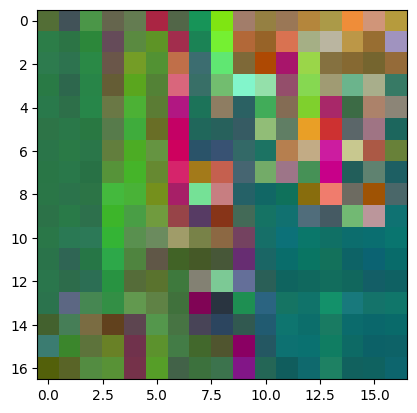

In [33]:
plt.figure()
plt.imshow(img)

In [ ]:
l

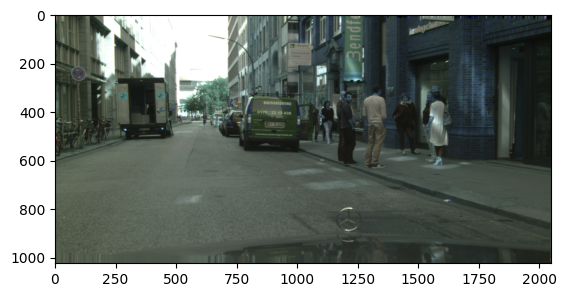

In [58]:
plt.imshow(img_);

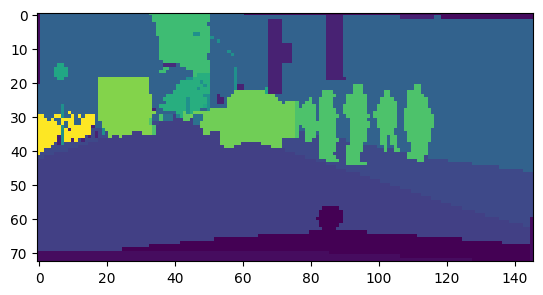

In [43]:
plt.imshow(black_img_new.reshape(73, -1))

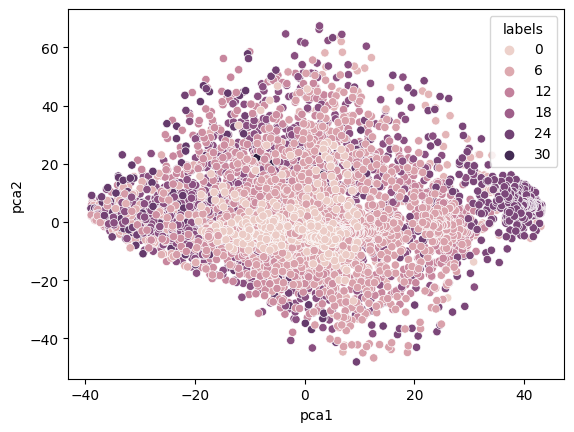

In [63]:
sns.scatterplot(df, x='pca1', y='pca2', hue='labels');

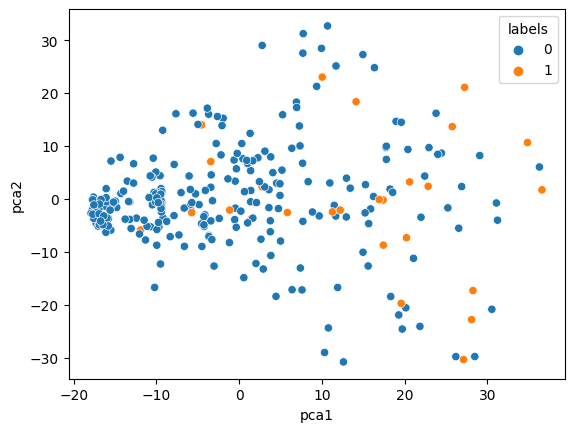

In [34]:
sns.scatterplot(df, x='pca1', y='pca2', hue='labels');

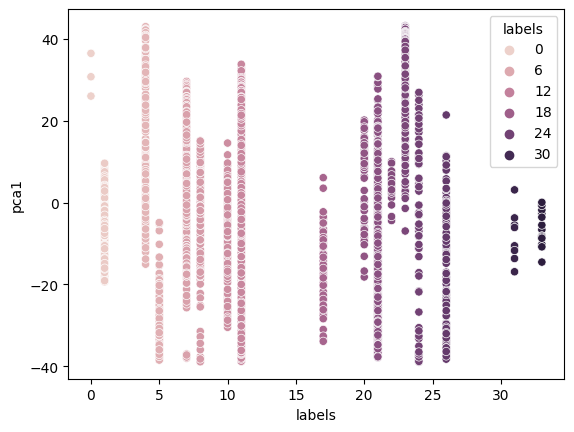

In [69]:
sns.scatterplot(df, y='pca1', x='labels', hue='labels');

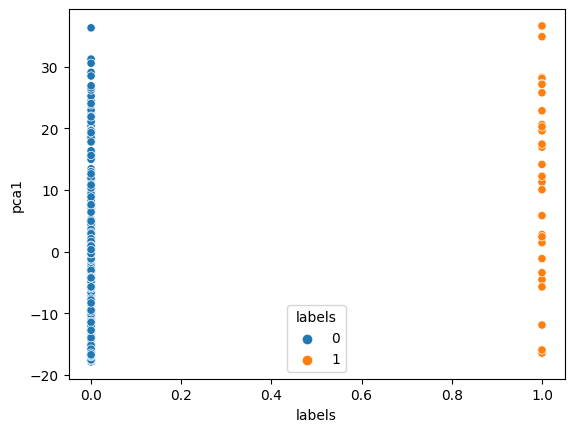

In [35]:
sns.scatterplot(df, y='pca1', x='labels', hue='labels');

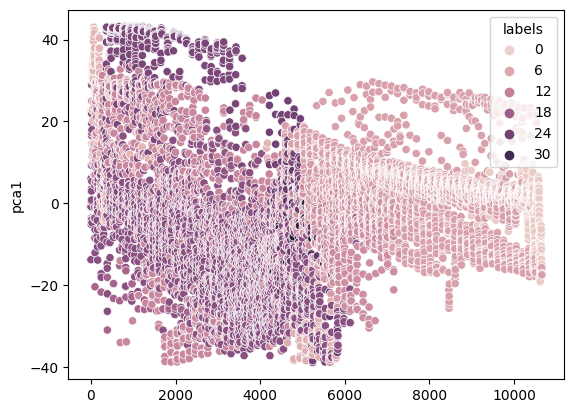

In [65]:
sns.scatterplot(df, y='pca1', x=np.arange(df.shape[0]), hue='labels');

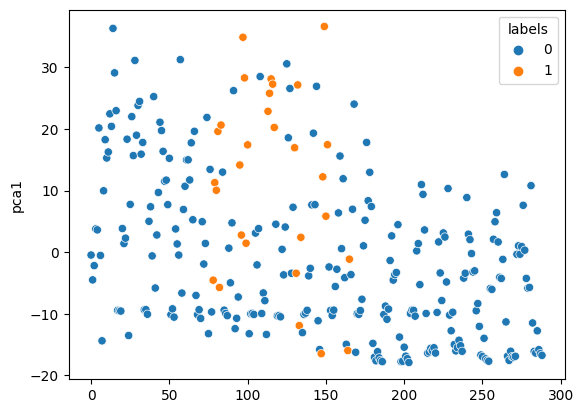

In [36]:
sns.scatterplot(df, y='pca1', x=np.arange(df.shape[0]), hue='labels');

In [ ]:
plt.plot(img_emb_low, '.');

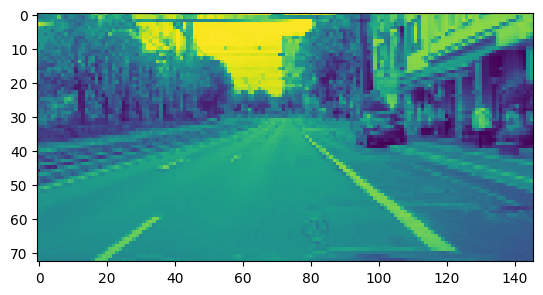

In [140]:
plt.imshow(img_emb_low.reshape(73, 146));